In [1]:
import pandas as pd

file_path = "/Users/sankalpajoshi/Downloads/Data Science Project Files/Commodity_Flux/CMO-Historical-Data-Monthly.xlsx"

# Inspect available sheets
xl = pd.ExcelFile(file_path)
print("Sheets:", xl.sheet_names)

# Load the first sheet that contains monthly prices
df_raw = pd.read_excel(file_path, sheet_name=xl.sheet_names[0])

# Preview
print(df_raw.head(10))


Sheets: ['AFOSHEET', 'Monthly Prices', 'Monthly Indices', 'Description', 'Index Weights']
Empty DataFrame
Columns: []
Index: []


In [7]:
import pandas as pd
import re

file_path = "/Users/sankalpajoshi/Downloads/Data Science Project Files/Commodity_Flux/CMO-Historical-Data-Monthly.xlsx"

# 1) Load raw with NO header
raw = pd.read_excel(file_path, sheet_name="Monthly Prices", header=None)

# 2) Find the header row that contains commodity names (robust search)
needles = ["aluminum","copper","iron ore","zinc","nickel","lead","tin","gold","silver"]
header_idx = None
for i in range(min(20, len(raw))):  # scan top 20 rows
    row_vals = raw.iloc[i].astype(str).str.strip().str.lower().tolist()
    if any(any(n in v for n in needles) for v in row_vals):
        header_idx = i
        break
if header_idx is None:
    raise ValueError("Could not locate header row with commodity names.")

# 3) Set header to that row; data starts two rows below (skip units row)
df = raw.copy()
df.columns = df.iloc[header_idx]
df = df.iloc[header_idx+2:].reset_index(drop=True)

# 4) Ensure first column is Date
first_col_name = df.columns[0]
df = df.rename(columns={first_col_name: "Date"})

# 5) Coerce Date (handles real dates, 'YYYY-MM', and 'YYYYMmm')
s = df["Date"].astype(str).str.strip()
dt = pd.to_datetime(s, errors="coerce")
mask_yM = dt.isna() & s.str.match(r"^\d{4}M\d{2}$", na=False)
dt.loc[mask_yM] = pd.to_datetime(s.loc[mask_yM].str.replace("M", "-", regex=False) + "-01", errors="coerce")
mask_y_dash_m = dt.isna() & s.str.match(r"^\d{4}-\d{2}$", na=False)
dt.loc[mask_y_dash_m] = pd.to_datetime(s.loc[mask_y_dash_m] + "-01", errors="coerce")
df["Date"] = dt
df = df[df["Date"].notna()].reset_index(drop=True)

# 6) Convert numeric columns
for c in df.columns[1:]:
    df[c] = pd.to_numeric(pd.Series(df[c]).astype(str).str.replace(",", "", regex=False), errors="coerce")

# 7) (Optional) Keep metals only
metal_cols = [c for c in df.columns if any(k in str(c).lower() for k in needles)]
keep = ["Date"] + metal_cols
df_metals = df[keep].copy()

print(df_metals.head())
print("\nColumns:", list(df_metals.columns))


4       Date    Aluminum  Iron ore, cfr spot  Copper   Lead     Tin  Nickel  \
0 1960-01-01  511.471832               11.42  715.40  206.1  2180.4  1631.0   
1 1960-02-01  511.471832               11.42  728.19  203.7  2180.4  1631.0   
2 1960-03-01  511.471832               11.42  684.94  210.3  2173.8  1631.0   
3 1960-04-01  511.471832               11.42  723.11  213.6  2178.2  1631.0   
4 1960-05-01  511.471832               11.42  684.75  213.4  2162.7  1631.0   

4   Zinc   Gold  Platinum  Silver  
0  260.8  35.27      83.5  0.9137  
1  244.9  35.27      83.5  0.9137  
2  248.7  35.27      83.5  0.9137  
3  254.6  35.27      83.5  0.9137  
4  253.8  35.27      83.5  0.9137  

Columns: ['Date', 'Aluminum', 'Iron ore, cfr spot', 'Copper', 'Lead', 'Tin', 'Nickel', 'Zinc', 'Gold', 'Platinum', 'Silver']


/var/folders/39/6qcvlfhx1bl5s9rkl2bkr13w0000gn/T/ipykernel_12997/638306748.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(s, errors="coerce")


In [8]:
# Parse dates explicitly: most entries are YYYY-MM format
s = df["Date"].astype(str).str.strip()

# Handle 'YYYY-MM'
mask = s.str.match(r"^\d{4}-\d{2}$", na=False)
df.loc[mask, "Date"] = pd.to_datetime(s[mask] + "-01", format="%Y-%m-%d", errors="coerce")

# Handle 'YYYYMmm' format (e.g. 1960M01)
mask2 = s.str.match(r"^\d{4}M\d{2}$", na=False)
df.loc[mask2, "Date"] = pd.to_datetime(
    s[mask2].str.replace("M", "-", regex=False) + "-01",
    format="%Y-%m-%d",
    errors="coerce"
)

# Now ensure type
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


In [10]:
import pandas as pd
import numpy as np

# --- pick UK-relevant commodities ---
commodities = ["Aluminum", "Copper", "Iron ore, cfr spot", "Nickel", "Zinc"]

# tidy subset
df_sub = df[["Date"] + commodities].dropna().copy()
df_sub = df_sub.set_index("Date").sort_index()

# monthly returns
rets = df_sub.pct_change()

# rolling vols (precompute for dashboard)
def roll_vol(window):
    return rets.rolling(window=window, min_periods=window).std()

vol6  = roll_vol(6)
vol12 = roll_vol(12)
vol24 = roll_vol(24)

# composite (mean across basket)
vol12["UK_Vol_Index"] = vol12[commodities].mean(axis=1)

# export a long CSV for auditing
out = vol12.reset_index().melt(id_vars="Date", var_name="Series", value_name="Volatility")
out.to_csv("uk_raw_material_volatility_12m.csv", index=False)
print("Saved: uk_raw_material_volatility_12m.csv")


Saved: uk_raw_material_volatility_12m.csv


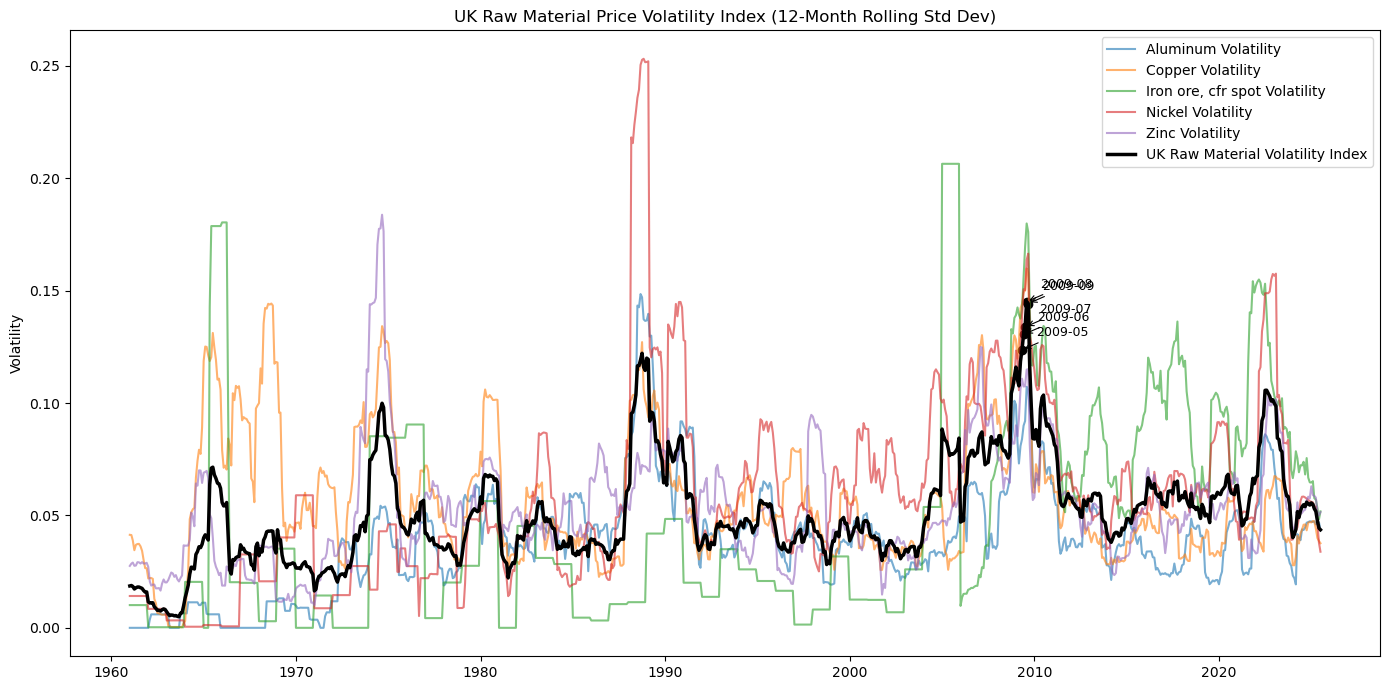

Saved: uk_volatility_index_12m.png


In [11]:
import matplotlib.pyplot as plt

series = vol12[commodities]
comp   = vol12["UK_Vol_Index"]

plt.figure(figsize=(14,7))
for c in commodities:
    plt.plot(series.index, series[c], alpha=0.6, label=f"{c} Volatility")

plt.plot(comp.index, comp, color="black", linewidth=2.5, label="UK Raw Material Volatility Index")
plt.title("UK Raw Material Price Volatility Index (12-Month Rolling Std Dev)")
plt.ylabel("Volatility")
plt.legend()

# annotate top 5 composite spikes
topN = comp.sort_values(ascending=False).head(5)
for dt, val in topN.items():
    plt.scatter(dt, val, color="black")
    plt.annotate(dt.strftime("%Y-%m"), xy=(dt, val), xytext=(10,10),
                 textcoords="offset points", fontsize=9,
                 arrowprops=dict(arrowstyle="->", lw=0.8))

plt.tight_layout()
plt.savefig("uk_volatility_index_12m.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: uk_volatility_index_12m.png")


In [12]:
# Top 10 spikes (composite)
top10 = comp.sort_values(ascending=False).head(10).rename("Volatility").reset_index()
top10["Rank"] = range(1, len(top10)+1)
top10 = top10[["Rank", "Date", "Volatility"]]
print("Top 10 composite spikes:")
print(top10)

# Decade averages (composite)
decade = comp.copy()
decade.index = decade.index.to_period("Y").to_timestamp()
decade_df = decade.groupby((decade.index.year//10)*10).mean().rename("Avg_Volatility").reset_index()
decade_df.rename(columns={"Date":"Decade", "index":"Decade"}, inplace=True)
decade_df["Decade"] = decade_df["Decade"].astype(int)
print("\nComposite volatility — decade averages:")
print(decade_df)

# Optional: export
top10.to_csv("uk_volatility_top10_spikes.csv", index=False)
decade_df.to_csv("uk_volatility_decade_averages.csv", index=False)
print("Saved: top10 + decade CSVs")


Top 10 composite spikes:
   Rank       Date  Volatility
0     1 2009-08-01    0.145103
1     2 2009-09-01    0.144257
2     3 2009-07-01    0.133832
3     4 2009-06-01    0.130520
4     5 2009-05-01    0.123662
5     6 1988-10-01    0.122128
6     7 1989-01-01    0.119983
7     8 1989-02-01    0.119407
8     9 1988-09-01    0.119186
9    10 2009-04-01    0.118583

Composite volatility — decade averages:
   Decade  Avg_Volatility
0    1960        0.028914
1    1970        0.042969
2    1980        0.053036
3    1990        0.047388
4    2000        0.064352
5    2010        0.058770
6    2020        0.064765
Saved: top10 + decade CSVs


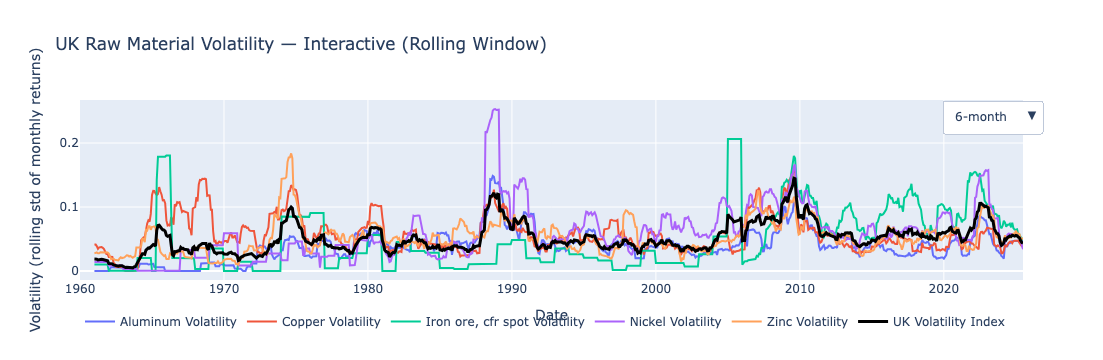

Saved: uk_volatility_dashboard.html


In [13]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# precompute composites for all windows
vol6_comp  = vol6[commodities].mean(axis=1).rename("UK_Vol_Index_6m")
vol12_comp = vol12["UK_Vol_Index"].rename("UK_Vol_Index_12m")
vol24_comp = vol24[commodities].mean(axis=1).rename("UK_Vol_Index_24m")

# build traces for 12m as default
fig = go.Figure()

# commodity traces (one per commodity; default = 12m)
for c in commodities:
    fig.add_trace(go.Scatter(x=vol12.index, y=vol12[c], mode="lines",
                             name=f"{c} Volatility"))

# composite trace
fig.add_trace(go.Scatter(x=vol12_comp.index, y=vol12_comp.values, mode="lines",
                         name="UK Volatility Index", line=dict(width=3, color="black")))

# buttons to swap window
def make_update(vol_df, comp_series):
    y = [vol_df[c].values for c in commodities] + [comp_series.values]
    return {"y": y, "x": [vol_df.index]*len(commodities) + [comp_series.index]}

buttons = [
    dict(label="6-month",  method="update", args=[make_update(vol6,  vol6_comp)]),
    dict(label="12-month", method="update", args=[make_update(vol12, vol12_comp)]),
    dict(label="24-month", method="update", args=[make_update(vol24, vol24_comp)]),
]

fig.update_layout(
    title="UK Raw Material Volatility — Interactive (Rolling Window)",
    xaxis_title="Date",
    yaxis_title="Volatility (rolling std of monthly returns)",
    updatemenus=[dict(type="dropdown", x=1.02, y=1, showactive=True, buttons=buttons)],
    legend=dict(orientation="h", y=-0.15)
)

fig.show()
# Optional: save a standalone HTML
fig.write_html("uk_volatility_dashboard.html")
print("Saved: uk_volatility_dashboard.html")


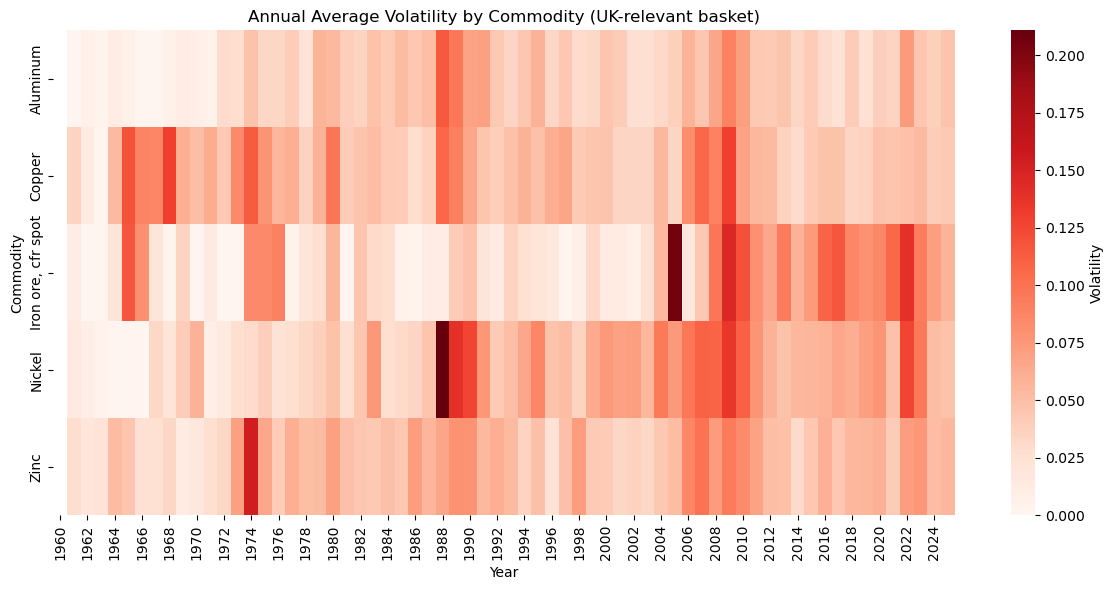

Saved: uk_volatility_heatmap.png


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: compute annual average volatility from 12m rolling ---
annual_vol = vol12[commodities].copy()
annual_vol["Year"] = annual_vol.index.year
annual_avg = annual_vol.groupby("Year").mean()

# --- Step 2: heatmap ---
plt.figure(figsize=(12,6))
sns.heatmap(annual_avg.T, cmap="Reds", annot=False, cbar_kws={'label': 'Volatility'})
plt.title("Annual Average Volatility by Commodity (UK-relevant basket)")
plt.ylabel("Commodity")
plt.xlabel("Year")
plt.tight_layout()
plt.savefig("uk_volatility_heatmap.png", dpi=300)
plt.show()
print("Saved: uk_volatility_heatmap.png")
